Building dimensions (Depth, Height, Width): (2, 50, 50)


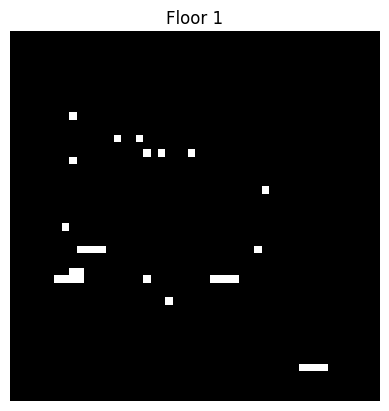

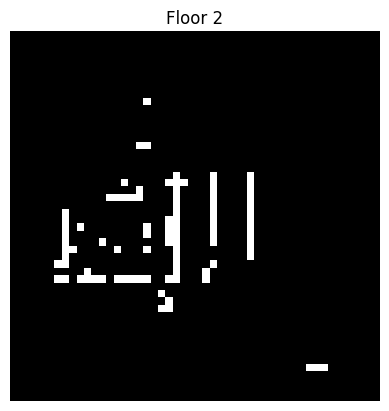

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_floor_plan(image_path, target_size):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise FileNotFoundError(f"Cannot load image: {image_path}")
    
    img = cv2.resize(img, target_size)
    _, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    h, w = img.shape
    floor_plan = np.zeros((h, w), dtype=int)
    
    for contour in contours:
        cv2.drawContours(floor_plan, [contour], -1, 1, thickness=cv2.FILLED)
    
    return floor_plan

def process_building(floor_plan_paths, target_size):
    floors = [process_floor_plan(path, target_size) for path in floor_plan_paths]
    building = np.stack(floors, axis=0)
    return building

# 예제 사용법
# floor_plan_paths = ["floor1.jpg", "floor2.jpg", "floor3.jpg"]
floor_plan_paths = ["floor11.png", "floor22.png"]
target_size = (50, 50)

try:
    eval = process_building(floor_plan_paths, target_size)
    
    # 배열의 높이, 너비, 크기를 확인합니다.
    height, width = target_size
    depth = len(floor_plan_paths)
    
    print(f"Building dimensions (Depth, Height, Width): ({depth}, {height}, {width})")
    
    # 배열 전체를 출력합니다.
    for d in range(depth):
        plt.figure()
        plt.imshow(eval[d], cmap='gray', interpolation='none')
        plt.title(f'Floor {d + 1}')
        plt.axis('off')  # 축을 숨깁니다.
        plt.show()
    
except FileNotFoundError as e:
    print(e)

In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from tqdm import tqdm
import matplotlib.pyplot as plt

# 랜덤한 환경 생성 함수
def create_random_environment(shape, num_obstacles):
    env = np.zeros(shape)
    for _ in range(num_obstacles):
        layer = np.random.randint(0, shape[0])
        start_row = np.random.randint(0, shape[1] - 10)
        start_col = np.random.randint(0, shape[2] - 10)
        direction = np.random.choice(['horizontal', 'vertical'])
        
        if direction == 'horizontal':
            env[layer, start_row, start_col:start_col + 10] = 1
        else:
            env[layer, start_row:start_row + 10, start_col] = 1
    
    return env

# 랜덤한 가상환경 10개 생성
num_environments = 10
environments = []

for _ in range(num_environments):
    env_shape = (3, 50, 50)
    num_obstacles = np.random.randint(5, 15)  # 장애물의 개수를 랜덤하게 설정
    new_environment = create_random_environment(env_shape, num_obstacles)
    environments.append(new_environment)

In [3]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from tqdm import tqdm
import matplotlib.pyplot as plt

# 환경 클래스 정의
class GridEnvironment:
    def __init__(self, building):
        self.building = building
        self.dimensions = building.shape
        self.start_position = self.get_random_start_position()
        self.agent_position = self.start_position
        self.exit_position = (0, 0, 0)

    def get_random_start_position(self):
        while True:
            position = (random.randint(0, self.dimensions[0] - 1),
                        random.randint(0, self.dimensions[1] - 1),
                        random.randint(0, self.dimensions[2] - 1))
            if self.building[position] == 0:
                return position

    def reset(self):
        self.agent_position = self.get_random_start_position()
        return self.agent_position

    def step(self, action):
        new_position = list(self.agent_position)
        if action == 0:  # 상
            new_position[1] -= 1
        elif action == 1:  # 하
            new_position[1] += 1
        elif action == 2:  # 좌
            new_position[2] -= 1
        elif action == 3:  # 우
            new_position[2] += 1
        elif action == 4:  # 위층
            new_position[0] -= 1
        elif action == 5:  # 아래층
            new_position[0] += 1

        # 범위를 벗어나지 않도록 처리
        new_position[0] = np.clip(new_position[0], 0, self.dimensions[0] - 1)
        new_position[1] = np.clip(new_position[1], 0, self.dimensions[1] - 1)
        new_position[2] = np.clip(new_position[2], 0, self.dimensions[2] - 1)
        
        new_position = tuple(new_position)

        if self.building[new_position] == 1:
            reward = -5  # 부정적 보상 감소
            done = False
        elif new_position == self.exit_position:
            reward = 50  # 긍정적 보상 감소
            done = True
        else:
            old_distance = np.linalg.norm(np.array(self.agent_position) - np.array(self.exit_position))
            new_distance = np.linalg.norm(np.array(new_position) - np.array(self.exit_position))
            distance_change = old_distance - new_distance
            reward = -1
            if distance_change > 0:
                reward += distance_change * 5  # 추가 보상 증가
            done = False
            self.agent_position = new_position

        return new_position, reward, done

class PPOPolicy(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PPOPolicy, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.softmax(x, dim=-1)

class ValueNetwork(nn.Module):
    def __init__(self, input_dim):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# PPO 알고리즘 클래스 정의
class PPO:
    def __init__(self, policy, value, policy_lr=1e-7, value_lr=1e-7, gamma=0.90, clip_ratio=0.2, device='cpu'):
        self.policy = policy.to(device)
        self.value = value.to(device)
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=policy_lr)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=value_lr)
        self.gamma = gamma
        self.clip_ratio = clip_ratio
        self.device = device

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        probs = self.policy(state)
        dist = Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def compute_returns(self, rewards, masks):
        returns = []
        R = 0
        for reward, mask in zip(reversed(rewards), reversed(masks)):
            R = reward + self.gamma * R * mask
            returns.insert(0, R)
        return returns

    def update(self, trajectories):
        states = torch.FloatTensor([traj[0] for traj in trajectories]).to(self.device)
        actions = torch.LongTensor([traj[1] for traj in trajectories]).unsqueeze(1).to(self.device)
        old_log_probs = torch.cat([traj[2] for traj in trajectories]).to(self.device).detach()
        rewards = [traj[3] for traj in trajectories]
        masks = [traj[4] for traj in trajectories]

        returns = self.compute_returns(rewards, masks)
        returns = torch.FloatTensor(returns).unsqueeze(1).to(self.device)

        values = self.value(states)
        advantages = (returns - values).detach()

        for _ in range(10):  # 10번 업데이트
            log_probs = self.policy(states).gather(1, actions)
            ratio = torch.exp(log_probs - old_log_probs)

            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()

            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            self.policy_optimizer.step()

            value_loss = (returns - self.value(states)).pow(2).mean()

            self.value_optimizer.zero_grad()
            value_loss.backward()
            self.value_optimizer.step()

# CUDA 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# PPO 초기화
input_dim = 3  # 에이전트의 위치는 3차원
output_dim = 6  # 행동은 6가지 (상, 하, 좌, 우, 위층, 아래층)
policy = PPOPolicy(input_dim, output_dim)
value = ValueNetwork(input_dim)
ppo = PPO(policy, value, device=device)

  0%|                                                                               | 1/5000 [00:01<1:48:18,  1.30s/it]

Episode 0, Steps 699, Reward -0.1742430504416017


  2%|█▌                                                                           | 101/5000 [02:13<1:52:48,  1.38s/it]

Episode 100, Steps 699, Reward 2.6313197921648666


  4%|███                                                                          | 201/5000 [04:32<2:01:57,  1.52s/it]

Episode 200, Steps 699, Reward 3.174258695120443


  6%|████▋                                                                        | 301/5000 [07:21<2:27:07,  1.88s/it]

Episode 300, Steps 699, Reward -1


  8%|██████▏                                                                      | 401/5000 [10:05<2:03:32,  1.61s/it]

Episode 400, Steps 699, Reward 0.18033988749894903


 10%|███████▋                                                                     | 501/5000 [12:44<1:57:00,  1.56s/it]

Episode 500, Steps 699, Reward 2.7830382563086573


 12%|█████████▎                                                                   | 601/5000 [15:18<1:57:28,  1.60s/it]

Episode 600, Steps 699, Reward 2.5528810864600047


 14%|██████████▊                                                                  | 701/5000 [18:00<1:53:31,  1.58s/it]

Episode 700, Steps 699, Reward 2.7082869338697066


 16%|████████████▎                                                                | 801/5000 [20:35<1:34:53,  1.36s/it]

Episode 800, Steps 314, Reward 50


 18%|█████████████▉                                                               | 901/5000 [23:12<1:53:15,  1.66s/it]

Episode 900, Steps 699, Reward 2.477284977628088


 20%|███████████████▏                                                            | 1001/5000 [25:47<1:52:34,  1.69s/it]

Episode 1000, Steps 699, Reward 3.9259258654874483


 22%|████████████████▋                                                           | 1101/5000 [28:15<1:28:45,  1.37s/it]

Episode 1100, Steps 699, Reward 2.4279860643518134


 24%|██████████████████▎                                                         | 1201/5000 [30:46<1:31:12,  1.44s/it]

Episode 1200, Steps 699, Reward 1.7558765532122464


 26%|███████████████████▊                                                        | 1301/5000 [33:14<1:22:18,  1.34s/it]

Episode 1300, Steps 699, Reward -1


 28%|█████████████████████▎                                                      | 1401/5000 [35:50<1:41:07,  1.69s/it]

Episode 1400, Steps 699, Reward 1.216368076478048


 30%|██████████████████████▊                                                     | 1501/5000 [38:09<1:22:58,  1.42s/it]

Episode 1500, Steps 699, Reward -5


 32%|████████████████████████▎                                                   | 1601/5000 [40:38<1:33:15,  1.65s/it]

Episode 1600, Steps 699, Reward -0.9080048813793731


 34%|█████████████████████████▊                                                  | 1701/5000 [42:59<1:16:26,  1.39s/it]

Episode 1700, Steps 699, Reward 2.2013264792508256


 36%|████████████████████████████                                                  | 1801/5000 [45:13<56:16,  1.06s/it]

Episode 1800, Steps 322, Reward 50


 38%|████████████████████████████▉                                               | 1901/5000 [47:24<1:03:00,  1.22s/it]

Episode 1900, Steps 565, Reward 50


 40%|███████████████████████████████▏                                              | 2001/5000 [49:29<58:30,  1.17s/it]

Episode 2000, Steps 623, Reward 50


 42%|████████████████████████████████▊                                             | 2101/5000 [51:32<58:02,  1.20s/it]

Episode 2100, Steps 699, Reward 2.236877861040064


 44%|██████████████████████████████████▎                                           | 2201/5000 [53:28<54:33,  1.17s/it]

Episode 2200, Steps 699, Reward -0.1981868171955039


 46%|███████████████████████████████████▉                                          | 2301/5000 [55:29<57:41,  1.28s/it]

Episode 2300, Steps 699, Reward -1


 48%|█████████████████████████████████████▍                                        | 2401/5000 [57:25<46:53,  1.08s/it]

Episode 2400, Steps 699, Reward -1


 50%|███████████████████████████████████████                                       | 2501/5000 [59:24<53:07,  1.28s/it]

Episode 2500, Steps 699, Reward -1


 52%|███████████████████████████████████████▌                                    | 2601/5000 [1:01:16<42:28,  1.06s/it]

Episode 2600, Steps 699, Reward -1


 54%|█████████████████████████████████████████                                   | 2701/5000 [1:03:11<44:53,  1.17s/it]

Episode 2700, Steps 699, Reward -0.38447187191169707


 56%|██████████████████████████████████████████▌                                 | 2801/5000 [1:05:00<43:18,  1.18s/it]

Episode 2800, Steps 591, Reward 50


 58%|████████████████████████████████████████████                                | 2901/5000 [1:06:52<41:37,  1.19s/it]

Episode 2900, Steps 699, Reward 0.5820189530525797


 60%|█████████████████████████████████████████████▌                              | 3001/5000 [1:08:45<31:39,  1.05it/s]

Episode 3000, Steps 697, Reward 50


 62%|███████████████████████████████████████████████▏                            | 3101/5000 [1:10:43<37:07,  1.17s/it]

Episode 3100, Steps 650, Reward 50


 64%|████████████████████████████████████████████████▋                           | 3201/5000 [1:12:42<29:09,  1.03it/s]

Episode 3200, Steps 224, Reward 50


 66%|██████████████████████████████████████████████████▏                         | 3301/5000 [1:14:27<28:55,  1.02s/it]

Episode 3300, Steps 338, Reward 50


 68%|███████████████████████████████████████████████████▋                        | 3401/5000 [1:16:16<29:13,  1.10s/it]

Episode 3400, Steps 630, Reward 50


 70%|█████████████████████████████████████████████████████▏                      | 3501/5000 [1:18:06<22:34,  1.11it/s]

Episode 3500, Steps 363, Reward 50


 72%|██████████████████████████████████████████████████████▋                     | 3601/5000 [1:19:55<20:14,  1.15it/s]

Episode 3600, Steps 187, Reward 50


 74%|████████████████████████████████████████████████████████▎                   | 3701/5000 [1:21:39<26:08,  1.21s/it]

Episode 3700, Steps 699, Reward -1


 76%|█████████████████████████████████████████████████████████▊                  | 3801/5000 [1:23:18<15:40,  1.27it/s]

Episode 3800, Steps 270, Reward 50


 78%|███████████████████████████████████████████████████████████▎                | 3901/5000 [1:24:58<15:39,  1.17it/s]

Episode 3900, Steps 307, Reward 50


 80%|████████████████████████████████████████████████████████████▊               | 4001/5000 [1:26:31<12:05,  1.38it/s]

Episode 4000, Steps 198, Reward 50


 82%|██████████████████████████████████████████████████████████████▎             | 4101/5000 [1:28:15<15:38,  1.04s/it]

Episode 4100, Steps 301, Reward 50


 84%|███████████████████████████████████████████████████████████████▊            | 4201/5000 [1:29:50<15:24,  1.16s/it]

Episode 4200, Steps 656, Reward 50


 86%|█████████████████████████████████████████████████████████████████▍          | 4301/5000 [1:31:25<13:42,  1.18s/it]

Episode 4300, Steps 635, Reward 50


 88%|██████████████████████████████████████████████████████████████████▉         | 4401/5000 [1:33:01<11:36,  1.16s/it]

Episode 4400, Steps 699, Reward -1


 90%|████████████████████████████████████████████████████████████████████▍       | 4501/5000 [1:34:32<07:18,  1.14it/s]

Episode 4500, Steps 292, Reward 50


 92%|█████████████████████████████████████████████████████████████████████▉      | 4601/5000 [1:36:08<05:52,  1.13it/s]

Episode 4600, Steps 356, Reward 50


 94%|███████████████████████████████████████████████████████████████████████▍    | 4701/5000 [1:37:40<05:00,  1.01s/it]

Episode 4700, Steps 395, Reward 50


 96%|████████████████████████████████████████████████████████████████████████▉   | 4801/5000 [1:39:14<03:25,  1.03s/it]

Episode 4800, Steps 444, Reward 50


 98%|██████████████████████████████████████████████████████████████████████████▍ | 4901/5000 [1:40:48<01:47,  1.09s/it]

Episode 4900, Steps 699, Reward -1


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:42:24<00:00,  1.23s/it]


Training complete.
Models saved: ppo_policy7.pth, ppo_value7.pth


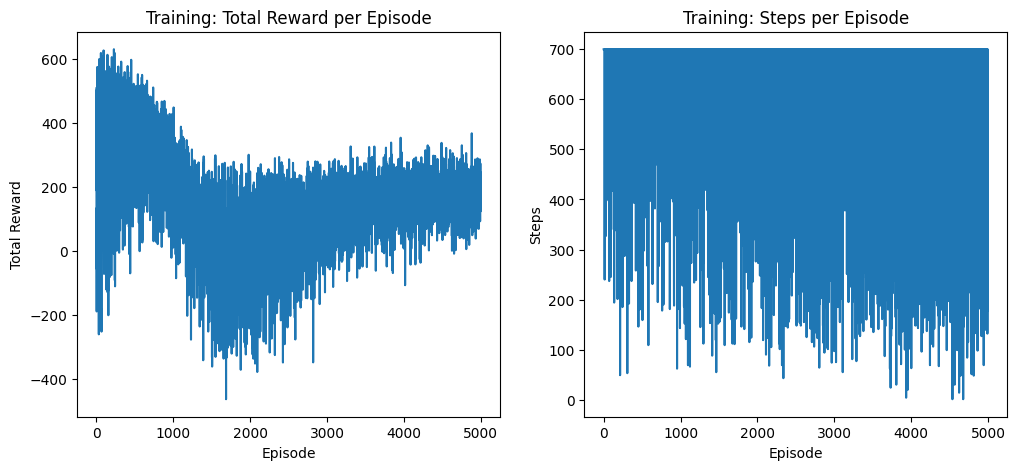

In [4]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from tqdm import tqdm
import matplotlib.pyplot as plt

# 학습
num_episodes = 5000
max_steps = 700

rewards_list = []
steps_list = []

for episode in tqdm(range(num_episodes)):  # tqdm을 사용하여 진행률 표시
    env = GridEnvironment(random.choice(environments))  # 랜덤한 환경 선택
    state = env.reset()
    trajectory = []

    episode_reward = 0
    for step in range(max_steps):
        action, log_prob = ppo.select_action(state)
        next_state, reward, done = env.step(action)
        mask = 0 if done else 1

        trajectory.append((state, action, log_prob, reward, mask))

        state = next_state
        episode_reward += reward

        if done:
            break

    ppo.update(trajectory)

    rewards_list.append(episode_reward)
    steps_list.append(step + 1)

    if episode % 100 == 0:
        print(f'Episode {episode}, Steps {step}, Reward {reward}')

print("Training complete.")

# 학습된 모델 저장
policy_path = "ppo_policy7.pth"
value_path = "ppo_value7.pth"

torch.save(policy.state_dict(), policy_path)
torch.save(value.state_dict(), value_path)

print(f"Models saved: {policy_path}, {value_path}")

# 모델 로드
# policy_loaded = PPOPolicy(input_dim, output_dim)
# value_loaded = ValueNetwork(input_dim)

# policy_loaded.load_state_dict(torch.load(policy_path))
# value_loaded.load_state_dict(torch.load(value_path))

# print("Models loaded successfully.")

# 학습 결과 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rewards_list)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training: Total Reward per Episode')

plt.subplot(1, 2, 2)
plt.plot(steps_list)
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Training: Steps per Episode')

plt.show()

In [5]:
def calculate_averages(lst, chunk_size):
    return [np.mean(lst[i:i + chunk_size]) for i in range(0, len(lst), chunk_size)]
    
rewards_avg_list = calculate_averages(rewards_list, 800)
steps_avg_list = calculate_averages(steps_list, 800)

print("Averaged rewards list:", rewards_avg_list)
print("Averaged steps list:", steps_avg_list)

# rewards_list를 문자열로 변환하여 파일에 쓰기
with open('rewards_avg_list9.txt', 'w') as f:
    f.write('\n'.join(map(str, rewards_avg_list)))

# steps_list를 문자열로 변환하여 파일에 쓰기
with open('steps_avg_list9.txt', 'w') as q:
    q.write('\n'.join(map(str, steps_avg_list)))

Averaged rewards list: [289.5666424824247, 151.17111668645683, 18.05826239396138, 90.76088095083078, 148.8732723951135, 168.80096479100916, 169.3047667292189]
Averaged steps list: [653.56125, 625.1275, 604.15, 564.8325, 507.64375, 466.1075, 461.68]


In [14]:
sum=0
for i in steps_avg_list:
    sum += i
print("steps_avg_list",sum/len(rewards_avg_list))

sum=0
for i in rewards_avg_list:
    sum += i
print("rewards_avg_list",sum/len(rewards_avg_list))



steps_avg_list 554.7289285714286
rewards_avg_list 148.0765580612879


Evaluation over 10000 episodes: Average Reward: 179.25968896425042, Average Steps: 465.983


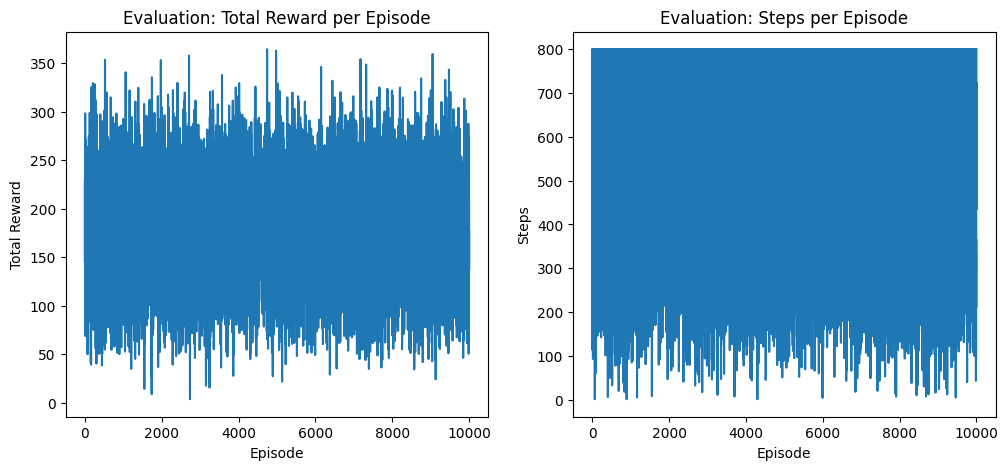

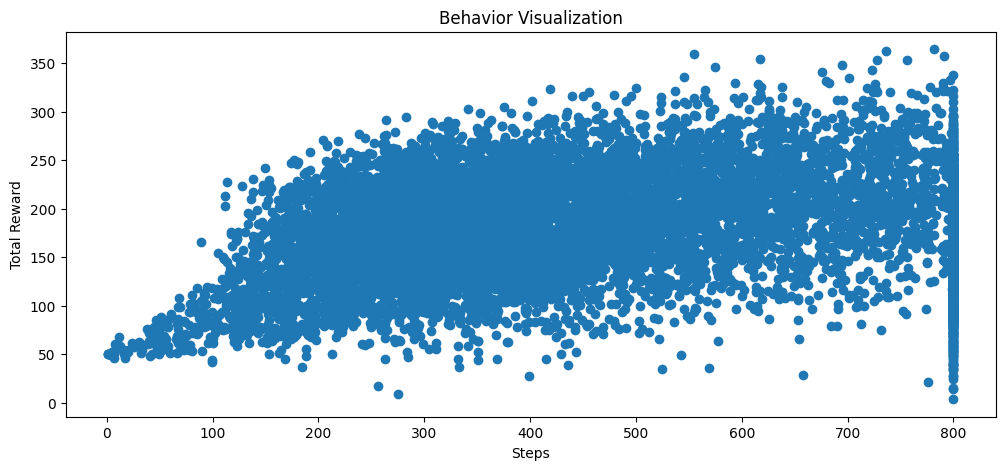

In [8]:
# 정책 평가 함수
def evaluate_policy(envs, policy, num_episodes=1000, max_steps=800):
    policy.eval()
    total_rewards = []
    total_steps = []

    with torch.no_grad():
        for episode in range(num_episodes):
            env = GridEnvironment(envs)  
            state = env.reset()
            episode_reward = 0
            for step in range(max_steps):
                action, _ = ppo.select_action(state)
                next_state, reward, done = env.step(action)
                episode_reward += reward
                state = next_state
                if done:
                    break
            total_rewards.append(episode_reward)
            total_steps.append(step + 1)

    avg_reward = np.mean(total_rewards)
    avg_steps = np.mean(total_steps)

    print(f"Evaluation over {num_episodes} episodes: Average Reward: {avg_reward}, Average Steps: {avg_steps}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Evaluation: Total Reward per Episode')

    plt.subplot(1, 2, 2)
    plt.plot(total_steps)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.title('Evaluation: Steps per Episode')

    plt.show()

    # 행동 패턴 시각화 추가
    visualize_behavior(total_rewards, total_steps)

def visualize_behavior(total_rewards, total_steps):
    plt.figure(figsize=(12, 5))
    plt.scatter(total_steps, total_rewards)
    plt.xlabel('Steps')
    plt.ylabel('Total Reward')
    plt.title('Behavior Visualization')
    plt.show()

# 학습된 정책 평가
evaluate_policy(eval, policy, num_episodes=10000, max_steps=800)